<a href="https://colab.research.google.com/github/galopyz/hprc/blob/main/circadian12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 24hr predictions

1. Train with 3000 genes.
2. Data_columns - Test_data_columns
3. For bulk data, fill missing data with 0.
4. Add columns to indicate missing genes and fill missing gene with 0.
  - Add data augmentation that does this on training data.
  - For some reason, data augmentation performed worse.
5. Use linear layer for 24hr prediction.
  - Trying on other bulk data.
6. New loss function.
  - Using modulo and sigmoid
7. Modified R2 score

## Import libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/'Colab Notebooks'
!pip -q install torcheval
!pip -q install datasets

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.5 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import torch
from torch import tensor
from torcheval.metrics import MulticlassAccuracy
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.augment import *
from miniai.xtras import *

In [3]:
from torch.nn import init
from functools import partial
from torch.optim import lr_scheduler
from torch import tensor,nn,optim

import fastcore.all as fc

In [4]:
import os
path = Path('data/circadian')

In [5]:
F.sigmoid(tensor(1)) * 26

tensor(19.0075)

In [6]:
29 % 24

5

In [7]:
loss_func = F.mse_loss

In [8]:
(F.sigmoid(tensor(3000)) * 36 - 6) % 24

tensor(6.)

In [9]:
class TimeLayer(nn.Module):
    def __init__(self, range = 36):
        super().__init__()
        self.range = range

    def forward(self, x):
        # return (F.sigmoid(x) * self.range - (self.range - 24)/2) % 24
        return (F.sigmoid(x) * self.range - (self.range - 24)/2)

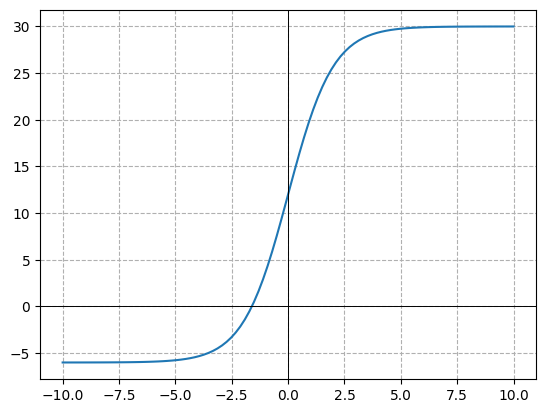

In [10]:
plot_func(lambda x: F.sigmoid(x) * 36 - (36 - 24)/2, start=-10, end=10)

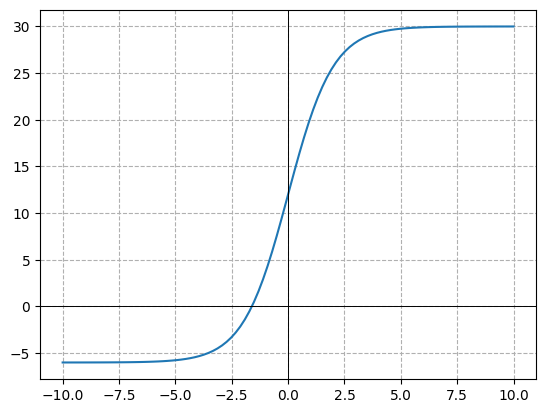

In [11]:
plot_func(TimeLayer(36), start=-10, end=10)

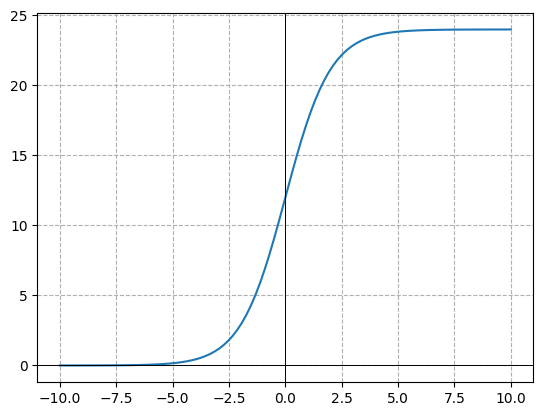

In [12]:
plot_func(TimeLayer(24), start=-10, end=10)

In [13]:
class Metric:
    def __init__(self): self.reset()

    def reset(self):
        self.ns, self.accs = [], []

    def update(self, preds, targs):
        res = self.compute(preds, targs)
        n = len(preds)
        self.ns.append(n)
        self.accs.append(res * n)

    def compute(self, preds, targs): return 0

    @property
    def value(self):
        return tensor(self.accs).sum() / tensor(self.ns).sum()

In [14]:
from torcheval.metrics import R2Score
metrics = MetricsCB(R2Score=R2Score())

In [ ]:
R

## Data

In [13]:
bulk = pd.read_csv(path/'sc_RNA_ct.csv', low_memory=False)
bulk.head()

,Unnamed: 0,AAACAGCCAGCAATAA.8,AAACGCGCAGTATGTT.8,AAAGCGGGTGCATCGG.8,AAAGGACGTAAGGTTT.8,AAAGGAGCAACCGCCA.8,AACCCGCAGGCCAATT.8,AACCCGCAGTCATTAG.8,AACTAGCTCGTACCGA.8,AACTAGCTCTGTAAGC.8,...,CTCCCTGAGAGCCGCT.2,CTTGCATGTAAGGTCC.2,GCTAAGTTCTAAGTGC.2,GCTCACAAGCTGGACC.2,GCTGCACAGTAGCGGG.2,GTCCAAGTCTACTAAG.2,TACCGTTGTTACGCAA.2,TCCATCATCAGGTTTA.2,TCGTTAGCAGTAGGAT.2,TGAACAGAGTGATTCA.2
0,Xkr4,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
1,Rp1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Sox17,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Mrpl15,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,Lypla1,1,4,0,0,2,6,2,5,0,...,0,0,0,2,0,0,1,1,0,0


In [14]:
bulk_tz = pd.read_csv(path/'sc_RNA_ZT.csv', low_memory=False)
bulk_tz.head()

,Unnamed: 0,ZT
0,AAACAGCCAGCAATAA-8,ZT18
1,AAACGCGCAGTATGTT-8,ZT18
2,AAAGCGGGTGCATCGG-8,ZT18
3,AAAGGACGTAAGGTTT-8,ZT18
4,AAAGGAGCAACCGCCA-8,ZT18


In [15]:
meta_data = pd.read_csv(path/'meta_data.csv', low_memory=False)
raw_data = pd.read_csv(path/'RNA_count_mat.csv', low_memory=False)

In [16]:
data = raw_data.set_index('gene').T
data = (data - data.mean(axis=0)) / data.std(axis=0)
df_mis = pd.DataFrame({f'{col}_missing':np.zeros(data.shape[0], dtype=int) for col in data.columns}, index=data.index)
data2 = data.join(df_mis)
df = data2.join(meta_data.set_index('cell_name'))
df['code'] = df.loc[:,'ZT'].str[-2:].map(float)

#### How should I normalize df with additioanl colums??

Add columns to indicate the column is missing or not.

### Bulk + scRNA-seq

In [17]:
raw_xr = pd.read_csv(path/'XR.csv', low_memory=False)
raw_xr.drop(columns=['Unnamed: 0'], inplace=True)

In [18]:
raw_gro = pd.read_csv(path/'gro.csv', low_memory=False)
raw_gro.drop(columns=['Unnamed: 0'], inplace=True)
raw_gro.rename(columns={'Symbol': 'ID'}, inplace=True)

In [19]:
raw_nascent = pd.read_csv(path/'Nascent.csv', low_memory=False)
raw_nascent.drop(columns=['Unnamed: 0'], inplace=True)

In [20]:
raw_bulk_data = pd.read_csv(path/'RNA.csv', low_memory=False)

In [21]:
bulk_data = raw_bulk_data.set_index('ID').T
bulk_data = (bulk_data - bulk_data.mean(axis=0)) / bulk_data.std(axis=0)
bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]

In [22]:
xr = raw_xr.set_index('ID').T
gro = raw_gro.set_index('ID').T
nascent = raw_nascent.set_index('ID').T
xr = (xr - xr.mean(axis=0)) / xr.std(axis=0)
gro = (gro - gro.mean(axis=0)) / gro.std(axis=0)
nascent = (nascent - nascent.mean(axis=0)) / nascent.std(axis=0)

bulk_data['code'] = [2,6,10,14,18,22,2,6,10,14,18,22]
xr['code'] = [0,4,8,12,16,20,0,4,8,12,16,20]
gro['code'] = [1,4,7,10,13,16,19,22]
nascent['code'] = [0,4,8,12,16,20,0,4,8,12,16,20]

In [23]:
bulk_genes_set = set(raw_bulk_data['ID'])
sc_genes = raw_data['gene']

In [24]:
genes = [gene for gene in sc_genes if gene in bulk_genes_set]

In [25]:
mis_genes = [gene for gene in sc_genes if gene not in bulk_genes_set]

`df2` is the bulk data used for testing.

In [26]:
df2 = pd.DataFrame(np.zeros((12, 6000), dtype=int), columns=data2.columns)

In [27]:
for gene in genes:
    df2[gene] = bulk_data[gene].values

In [28]:
for gene in sc_genes:
    if gene not in bulk_genes_set:
        df2[f'{gene}_missing'] = 1

In [29]:
df2['code'] = bulk_data['code'].values.astype(float)

<ipython-input-29-4ab7bf0d129f>:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df2['code'] = bulk_data['code'].values.astype(float)


In [30]:
def make_df(dataset):
    genes_set = set(dataset.columns[:-1])
    genes = [gene for gene in sc_genes if gene in genes_set]
    mis_genes = [gene for gene in sc_genes if gene not in genes_set]
    df = pd.DataFrame(np.zeros((dataset.shape[0], 6000), dtype=int), columns=data2.columns)
    for gene in genes:
        df[gene] = dataset[gene].values
    for gene in sc_genes:
        if gene not in genes_set:
            df[f'{gene}_missing'] = 1
    df['code'] = dataset['code'].values.astype(float)
    print(f'% missing: {len(mis_genes)/3000*100}%')
    return df

In [31]:
nascent_df = make_df(nascent)
xr_df = make_df(xr)
gro_df = make_df(gro)
rna_df = make_df(bulk_data)

<ipython-input-30-18a5fcd3a868>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%


<ipython-input-30-18a5fcd3a868>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%


<ipython-input-30-18a5fcd3a868>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


% missing: 47.56666666666667%
% missing: 47.56666666666667%


<ipython-input-30-18a5fcd3a868>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['code'] = dataset['code'].values.astype(float)


## Using Pytorch

In [32]:
t_dep = tensor(df['code'], dtype=torch.float)
indep_cols = list(df.columns)[:-2]
t_indep = tensor(df[indep_cols].values, dtype=torch.float32)

In [33]:
# from fastai.data.transforms import RandomSplitter
def RandomSplitter(valid_pct=0.2, seed=None):
    "Create function that splits `items` between train/val with `valid_pct` randomly."
    def _inner(o):
        if seed is not None: torch.manual_seed(seed)
        rand_idx = list(torch.randperm(len(o)).numpy())
        cut = int(valid_pct * len(o))
        return rand_idx[cut:],rand_idx[:cut]
    return _inner
trn_split,val_split=RandomSplitter(seed=42)(df)

In [34]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [35]:
trn_dep.unsqueeze_(-1), val_dep.unsqueeze_(-1)
trn_dep.shape, val_dep.shape

(torch.Size([12794, 1]), torch.Size([3198, 1]))

### DataLoaders

Pretty much the same as the previous approach with bulk data as the test data.

In [36]:
bs = 128
n_workers = 2

trn_dl = DataLoader(list(zip(trn_indep, trn_dep)), batch_size=bs, shuffle=True, num_workers=n_workers)
val_dl = DataLoader(list(zip(val_indep, val_dep)), batch_size=bs, shuffle=False, num_workers=n_workers)
dls = DataLoaders(trn_dl, val_dl)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb.shape

(torch.Size([128, 6000]), torch.Size([128, 1]))

In [37]:
def make_dl(df):

    tst_dep = tensor(df['code'], dtype=torch.float)
    tst_indep_cols = list(df.columns)[:-1]
    tst_indep = tensor(df[tst_indep_cols].values, dtype=torch.float32)
    tst_dep.unsqueeze_(-1)
    return DataLoader(list(zip(tst_indep, tst_dep)), shuffle=False, num_workers=n_workers)

In [38]:
nascent_dl = make_dl(nascent_df)
xr_dl = make_dl(xr_df)
gro_dl = make_dl(gro_df)
rna_dl = make_dl(rna_df)
tst_dls = {'nascent':nascent_dl, 'xr':xr_dl, 'gro':gro_dl, 'rna':rna_dl}

Changing the metric to R2Score.

In [39]:
from torcheval.metrics import R2Score
metrics = MetricsCB(R2Score=R2Score())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True)]

## Training

In [40]:
def get_model():
    return nn.Sequential(*[nn.Linear(len(indep_cols), 100), nn.ReLU(), nn.Linear(100, 100), nn.ReLU(), nn.Linear(100, 1), nn.Flatten(), TimeLayer()])

In [41]:
get_model()(xb).shape

torch.Size([128, 1])

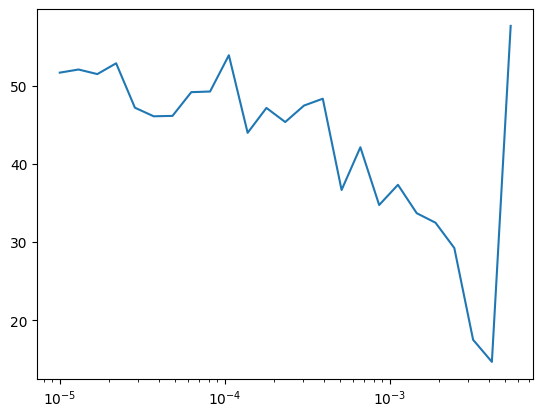

In [42]:
TrainLearner(get_model(), dls, loss_func=loss_func, cbs=cbs).lr_find()

R2Score,loss,epoch,train,time
0.769,10.841,0,True,00:01
0.928,3.372,0,False,00:00
0.948,2.450,1,True,00:02
0.934,3.063,1,False,00:00


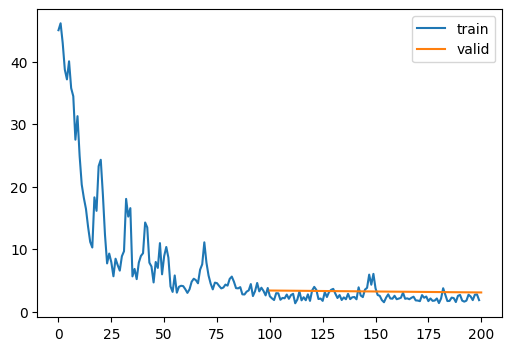

In [44]:
lr, epochs = 1e-3, 2
xtra = [get_sched(epochs, lr, dls)]
learn = TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs)
learn.fit(epochs)

## Ensemble

In [45]:
from functools import partial

In [46]:
class CapturePreds(Callback):
    def before_fit(self, learn): self.all_input, self.all_preds, self.all_targs = [], [], []

    def after_batch(self, learn):
        self.all_input.append(to_cpu(learn.batch[0]))
        self.all_preds.append(to_cpu(learn.preds))
        self.all_targs.append(to_cpu(learn.batch[1]))

    def after_fit(self, learn):
        self.all_input, self.all_preds, self.all_targs = map(torch.cat, [self.all_input, self.all_preds, self.all_targs])

In [47]:
def ensemble_model(nlearn, get_model = get_model, tst_dls=tst_dls, epochs=5, lr=.03, loss_func=loss_func, cbs=cbs, opt_func=optim.SGD):
    learners = [TrainLearner(get_model(), dls, lr=lr, loss_func=loss_func, cbs=cbs, opt_func=opt_func) for _ in range(nlearn)]
    print('Training models')
    for learn in learners:
        learn.fit(epochs)
    cps = [CapturePreds() for _ in range(nlearn)]
    print('Making inference on test data')
    for dl_name, tst_dl in tst_dls.items():
        for learn, cp in zip(learners, cps):
            learn.dls = DataLoaders((), tst_dl)
            learn.fit(1, train=False, cbs=cp)
        ap = torch.stack([cp.all_preds for cp in cps]).mean(0)
        metric = R2Score()
        metric.update(ap, cps[0].all_targs)
        print(f'Inference on {dl_name}')
        print('\t\tpreds, targs')
        print(torch.concat([ap, cps[0].all_targs], dim=1))
        print('result: ', metric.compute())

In [48]:
nlearn = 2

Training models


R2Score,loss,epoch,train,time
0.771,10.713,0,True,00:01
0.921,3.691,0,False,00:00
0.947,2.490,1,True,00:02
0.937,2.929,1,False,00:00


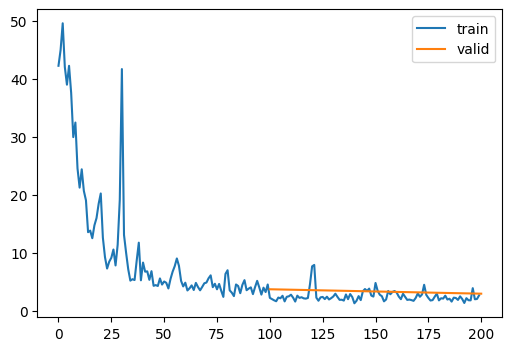

R2Score,loss,epoch,train,time
0.784,10.140,0,True,00:01
0.888,5.213,0,False,00:00
0.950,2.363,1,True,00:01
0.928,3.338,1,False,00:00


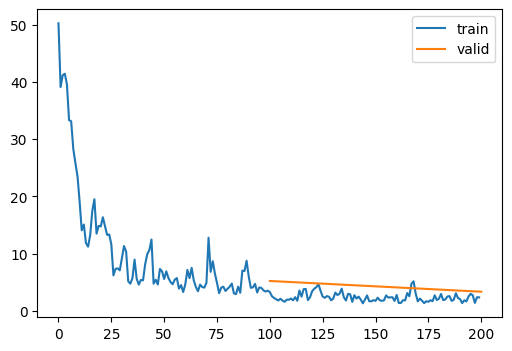

Making inference on test data


R2Score,loss,epoch,train,time
0.432,26.490,0,False,00:00


R2Score,loss,epoch,train,time
0.471,24.697,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 6.1738,  0.0000],
        [ 7.6477,  4.0000],
        [ 9.2544,  8.0000],
        [11.1844, 12.0000],
        [14.1517, 16.0000],
        [19.8851, 20.0000],
        [13.9661,  0.0000],
        [ 5.2111,  4.0000],
        [11.5617,  8.0000],
        [10.9714, 12.0000],
        [21.6220, 16.0000],
        [22.1769, 20.0000]])
result:  tensor(0.4577)


R2Score,loss,epoch,train,time
-0.332,62.154,0,False,00:00


R2Score,loss,epoch,train,time
-0.239,57.834,0,False,00:00


Inference on xr
		preds, targs
tensor([[ 6.0490,  0.0000],
        [10.9510,  4.0000],
        [11.1393,  8.0000],
        [10.3152, 12.0000],
        [15.1653, 16.0000],
        [ 9.2534, 20.0000],
        [18.8372,  0.0000],
        [14.9838,  4.0000],
        [11.9403,  8.0000],
        [12.5231, 12.0000],
        [16.2634, 16.0000],
        [16.5329, 20.0000]])
result:  tensor(-0.2806)


R2Score,loss,epoch,train,time
-0.081,51.079,0,False,00:00


R2Score,loss,epoch,train,time
-0.083,51.195,0,False,00:00


Inference on gro
		preds, targs
tensor([[20.8981,  1.0000],
        [ 5.9997,  4.0000],
        [ 8.8389,  7.0000],
        [ 8.9941, 10.0000],
        [13.3111, 13.0000],
        [15.8251, 16.0000],
        [19.6182, 19.0000],
        [20.4022, 22.0000]])
result:  tensor(-0.0777)


R2Score,loss,epoch,train,time
0.620,17.714,0,False,00:00


R2Score,loss,epoch,train,time
0.659,15.901,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 8.9250,  2.0000],
        [ 9.9556,  6.0000],
        [ 9.0182, 10.0000],
        [13.4889, 14.0000],
        [20.7377, 18.0000],
        [22.7080, 22.0000],
        [10.8924,  2.0000],
        [ 9.8965,  6.0000],
        [11.1248, 10.0000],
        [11.9717, 14.0000],
        [21.4817, 18.0000],
        [18.6675, 22.0000]])
result:  tensor(0.6506)


In [49]:
ensemble_model(nlearn, epochs=2, cbs=cbs, lr=1e-3, loss_func=loss_func)

In [50]:
def init_params(m, leaky=0.):
    if isinstance(m, (nn.Linear, nn.Conv2d)): init.kaiming_normal_(m.weight, a=leaky)

In [51]:
def get_model(): return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 1),
    TimeLayer(),
]).apply(init_params)

Improving the model with parameter initialization, lr_scheduler, and optimizer.

Training models


R2Score,loss,epoch,train,time
0.532,21.919,0,True,00:03
0.805,9.066,0,False,00:00
0.877,5.760,1,True,00:02
0.906,4.396,1,False,00:00


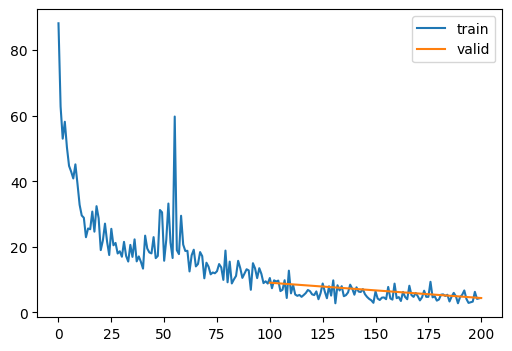

R2Score,loss,epoch,train,time
0.562,20.520,0,True,00:02
0.822,8.298,0,False,00:00
0.884,5.447,1,True,00:02
0.909,4.217,1,False,00:00


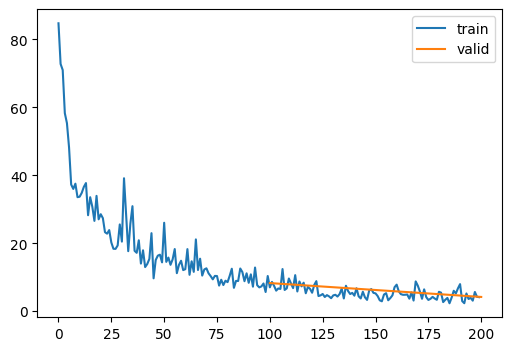

Making inference on test data


R2Score,loss,epoch,train,time
0.560,20.512,0,False,00:00


R2Score,loss,epoch,train,time
0.475,24.520,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 6.1730,  0.0000],
        [ 7.1549,  4.0000],
        [ 5.9777,  8.0000],
        [ 9.2292, 12.0000],
        [12.9575, 16.0000],
        [19.2008, 20.0000],
        [12.2855,  0.0000],
        [ 2.9022,  4.0000],
        [10.7913,  8.0000],
        [10.2747, 12.0000],
        [20.7455, 16.0000],
        [22.6406, 20.0000]])
result:  tensor(0.5319)


R2Score,loss,epoch,train,time
-0.081,50.426,0,False,00:00


R2Score,loss,epoch,train,time
-0.304,60.851,0,False,00:00


Inference on xr
		preds, targs
tensor([[ 0.3838,  0.0000],
        [ 7.7802,  4.0000],
        [11.0428,  8.0000],
        [10.3573, 12.0000],
        [14.7903, 16.0000],
        [10.5485, 20.0000],
        [19.3780,  0.0000],
        [16.0215,  4.0000],
        [11.6105,  8.0000],
        [11.5497, 12.0000],
        [16.0212, 16.0000],
        [16.9261, 20.0000]])
result:  tensor(-0.1784)


R2Score,loss,epoch,train,time
0.418,27.508,0,False,00:00


R2Score,loss,epoch,train,time
0.635,17.238,0,False,00:00


Inference on gro
		preds, targs
tensor([[13.9115,  1.0000],
        [ 4.7112,  4.0000],
        [ 8.3380,  7.0000],
        [ 9.9727, 10.0000],
        [13.0285, 13.0000],
        [16.1498, 16.0000],
        [19.3307, 19.0000],
        [20.7257, 22.0000]])
result:  tensor(0.5483)


R2Score,loss,epoch,train,time
0.887,5.285,0,False,00:00


R2Score,loss,epoch,train,time
0.819,8.440,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 4.9847,  2.0000],
        [ 8.1330,  6.0000],
        [ 9.7570, 10.0000],
        [13.0746, 14.0000],
        [19.5582, 18.0000],
        [23.2884, 22.0000],
        [ 7.1230,  2.0000],
        [ 7.1564,  6.0000],
        [10.1318, 10.0000],
        [12.3921, 14.0000],
        [21.5853, 18.0000],
        [18.2923, 22.0000]])
result:  tensor(0.8656)


In [52]:
lr, epochs = 6e-3, 2
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, loss_func=loss_func, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


R2Score,loss,epoch,train,time
0.371,29.496,0,True,00:02
0.661,15.791,0,False,00:00
0.823,8.316,1,True,00:02
0.887,5.258,1,False,00:00
0.927,3.399,2,True,00:02
0.919,3.785,2,False,00:00


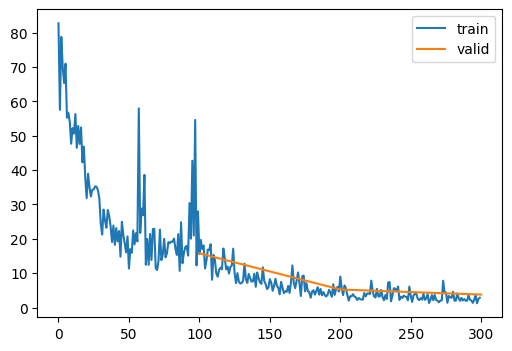

R2Score,loss,epoch,train,time
0.377,29.209,0,True,00:03
0.675,15.154,0,False,00:00
0.859,6.592,1,True,00:02
0.922,3.622,1,False,00:00
0.949,2.393,2,True,00:02
0.936,2.958,2,False,00:00


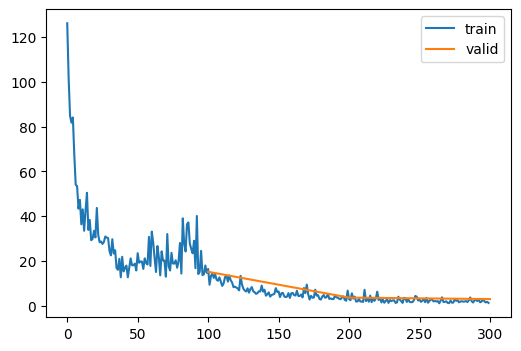

Making inference on test data


R2Score,loss,epoch,train,time
0.211,36.837,0,False,00:00


R2Score,loss,epoch,train,time
0.468,24.807,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 5.8178,  0.0000],
        [ 7.0033,  4.0000],
        [ 6.8391,  8.0000],
        [10.1635, 12.0000],
        [15.6220, 16.0000],
        [19.5145, 20.0000],
        [15.7525,  0.0000],
        [ 1.4581,  4.0000],
        [12.0188,  8.0000],
        [10.4236, 12.0000],
        [20.7305, 16.0000],
        [21.1219, 20.0000]])
result:  tensor(0.3842)


R2Score,loss,epoch,train,time
-0.481,69.097,0,False,00:00


R2Score,loss,epoch,train,time
-0.309,61.082,0,False,00:00


Inference on xr
		preds, targs
tensor([[ 0.6500,  0.0000],
        [12.6080,  4.0000],
        [11.3849,  8.0000],
        [11.0682, 12.0000],
        [14.9805, 16.0000],
        [ 9.6682, 20.0000],
        [19.9298,  0.0000],
        [16.3433,  4.0000],
        [11.0480,  8.0000],
        [12.3745, 12.0000],
        [16.3699, 16.0000],
        [16.1995, 20.0000]])
result:  tensor(-0.3718)


R2Score,loss,epoch,train,time
-0.373,64.884,0,False,00:00


R2Score,loss,epoch,train,time
0.487,24.236,0,False,00:00


Inference on gro
		preds, targs
tensor([[18.8304,  1.0000],
        [ 3.6801,  4.0000],
        [ 7.7816,  7.0000],
        [ 9.9037, 10.0000],
        [13.7069, 13.0000],
        [16.9362, 16.0000],
        [20.1873, 19.0000],
        [20.0315, 22.0000]])
result:  tensor(0.1394)


R2Score,loss,epoch,train,time
0.901,4.613,0,False,00:00


R2Score,loss,epoch,train,time
0.701,13.969,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 6.1804,  2.0000],
        [ 8.7829,  6.0000],
        [ 8.6399, 10.0000],
        [13.0231, 14.0000],
        [19.2995, 18.0000],
        [22.7260, 22.0000],
        [ 6.6720,  2.0000],
        [ 8.6562,  6.0000],
        [11.6653, 10.0000],
        [13.0875, 14.0000],
        [21.8113, 18.0000],
        [20.6877, 22.0000]])
result:  tensor(0.8590)


In [53]:
lr, epochs = 6e-3, 3
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


R2Score,loss,epoch,train,time
0.549,21.129,0,True,00:03
0.694,14.248,0,False,00:00
0.857,6.682,1,True,00:02
0.924,3.551,1,False,00:00
0.947,2.473,2,True,00:02
0.949,2.376,2,False,00:00
0.977,1.094,3,True,00:03
0.952,2.249,3,False,00:00


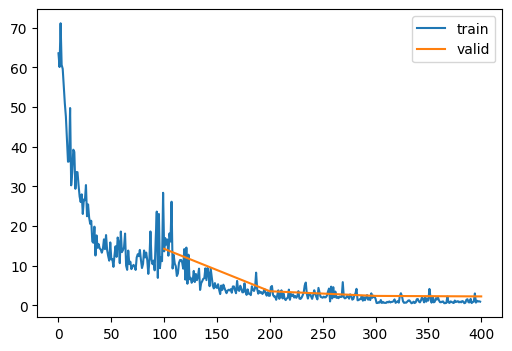

R2Score,loss,epoch,train,time
0.408,27.756,0,True,00:02
0.725,12.826,0,False,00:00
0.833,7.833,1,True,00:02
0.916,3.895,1,False,00:00
0.933,3.130,2,True,00:02
0.941,2.726,2,False,00:00
0.972,1.324,3,True,00:03
0.947,2.455,3,False,00:00


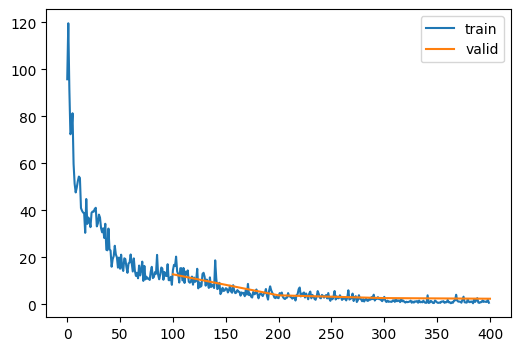

Making inference on test data


R2Score,loss,epoch,train,time
0.502,23.227,0,False,00:00


R2Score,loss,epoch,train,time
0.215,36.639,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 6.3853,  0.0000],
        [ 7.9497,  4.0000],
        [ 9.4552,  8.0000],
        [ 9.9869, 12.0000],
        [14.9699, 16.0000],
        [18.6319, 20.0000],
        [15.4677,  0.0000],
        [ 3.8145,  4.0000],
        [11.5738,  8.0000],
        [10.2312, 12.0000],
        [19.3899, 16.0000],
        [21.7646, 20.0000]])
result:  tensor(0.4013)


R2Score,loss,epoch,train,time
-0.290,60.210,0,False,00:00


R2Score,loss,epoch,train,time
-0.182,55.139,0,False,00:00


Inference on xr
		preds, targs
tensor([[ 0.5741,  0.0000],
        [ 9.1220,  4.0000],
        [10.5865,  8.0000],
        [11.1956, 12.0000],
        [15.0235, 16.0000],
        [ 8.5054, 20.0000],
        [19.3581,  0.0000],
        [15.5024,  4.0000],
        [11.1289,  8.0000],
        [12.0560, 12.0000],
        [14.9127, 16.0000],
        [17.6804, 20.0000]])
result:  tensor(-0.2328)


R2Score,loss,epoch,train,time
0.582,19.747,0,False,00:00


R2Score,loss,epoch,train,time
0.904,4.559,0,False,00:00


Inference on gro
		preds, targs
tensor([[ 8.6804,  1.0000],
        [ 5.7932,  4.0000],
        [ 9.1500,  7.0000],
        [ 9.8335, 10.0000],
        [13.7262, 13.0000],
        [16.7706, 16.0000],
        [19.3349, 19.0000],
        [19.8795, 22.0000]])
result:  tensor(0.8080)


R2Score,loss,epoch,train,time
0.861,6.495,0,False,00:00


R2Score,loss,epoch,train,time
0.825,8.181,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 6.5508,  2.0000],
        [10.5527,  6.0000],
        [10.0006, 10.0000],
        [13.2104, 14.0000],
        [20.0037, 18.0000],
        [21.3972, 22.0000],
        [ 5.5577,  2.0000],
        [ 9.8571,  6.0000],
        [10.6950, 10.0000],
        [12.6351, 14.0000],
        [20.0647, 18.0000],
        [20.2790, 22.0000]])
result:  tensor(0.8508)


In [54]:
lr, epochs = 6e-3, 4
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

We train with a lower learning rate.

Training models


R2Score,loss,epoch,train,time
0.207,37.156,0,True,00:02
0.735,12.321,0,False,00:00
0.848,7.144,1,True,00:02
0.804,9.138,1,False,00:00
0.942,2.741,2,True,00:03
0.812,8.739,2,False,00:00


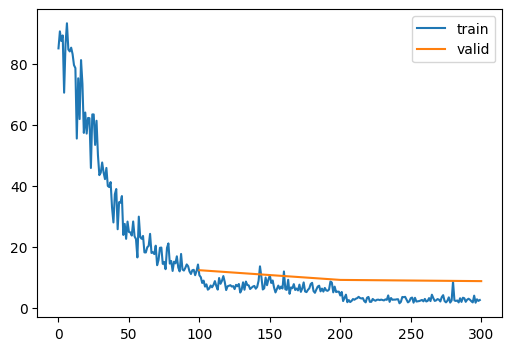

R2Score,loss,epoch,train,time
0.123,41.091,0,True,00:02
0.690,14.460,0,False,00:00
0.835,7.734,1,True,00:02
0.789,9.835,1,False,00:00
0.932,3.190,2,True,00:02
0.800,9.322,2,False,00:00


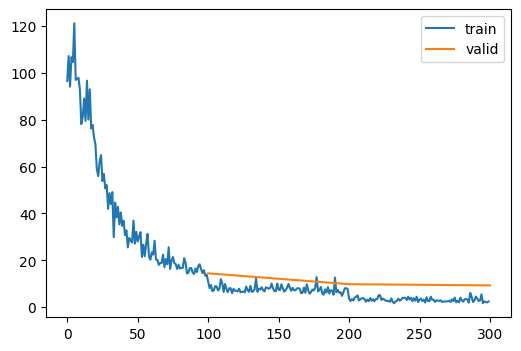

Making inference on test data


R2Score,loss,epoch,train,time
0.355,30.119,0,False,00:00


R2Score,loss,epoch,train,time
0.050,44.315,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 5.9804,  0.0000],
        [ 7.9445,  4.0000],
        [ 6.6060,  8.0000],
        [ 9.6071, 12.0000],
        [11.3599, 16.0000],
        [20.1269, 20.0000],
        [13.2489,  0.0000],
        [ 3.8415,  4.0000],
        [12.1592,  8.0000],
        [ 7.9152, 12.0000],
        [24.5944, 16.0000],
        [24.6876, 20.0000]])
result:  tensor(0.3109)


R2Score,loss,epoch,train,time
-0.172,54.686,0,False,00:00


R2Score,loss,epoch,train,time
-0.229,57.360,0,False,00:00


Inference on xr
		preds, targs
tensor([[ 1.9107,  0.0000],
        [ 7.3116,  4.0000],
        [ 8.5499,  8.0000],
        [10.6459, 12.0000],
        [16.9300, 16.0000],
        [10.6015, 20.0000],
        [19.1343,  0.0000],
        [15.7094,  4.0000],
        [11.7038,  8.0000],
        [12.1704, 12.0000],
        [17.1054, 16.0000],
        [16.7910, 20.0000]])
result:  tensor(-0.1329)


R2Score,loss,epoch,train,time
0.690,14.666,0,False,00:00


R2Score,loss,epoch,train,time
-0.002,47.359,0,False,00:00


Inference on gro
		preds, targs
tensor([[13.5803,  1.0000],
        [ 8.2902,  4.0000],
        [ 9.2362,  7.0000],
        [ 9.9984, 10.0000],
        [14.0923, 13.0000],
        [15.4620, 16.0000],
        [21.3393, 19.0000],
        [23.2354, 22.0000]])
result:  tensor(0.4970)


R2Score,loss,epoch,train,time
0.668,15.497,0,False,00:00


R2Score,loss,epoch,train,time
0.180,38.280,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 9.1958,  2.0000],
        [10.6577,  6.0000],
        [ 8.6261, 10.0000],
        [10.9215, 14.0000],
        [24.1991, 18.0000],
        [21.6652, 22.0000],
        [11.7768,  2.0000],
        [ 5.9377,  6.0000],
        [10.8863, 10.0000],
        [12.6756, 14.0000],
        [22.2701, 18.0000],
        [17.6863, 22.0000]])
result:  tensor(0.5387)


In [55]:
lr, epochs = 6e-4, 3
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


R2Score,loss,epoch,train,time
-0.163,54.511,0,True,00:02
0.607,18.327,0,False,00:00
0.785,10.092,1,True,00:02
0.757,11.333,1,False,00:00
0.902,4.599,2,True,00:03
0.776,10.423,2,False,00:00
0.956,2.082,3,True,00:03
0.778,10.338,3,False,00:00


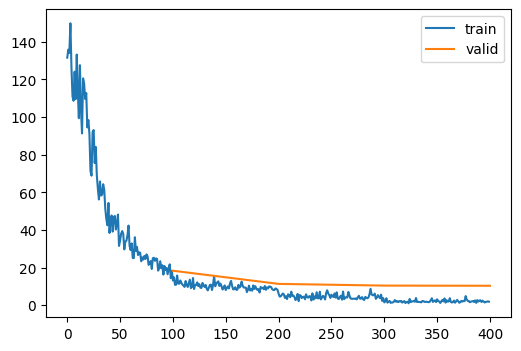

R2Score,loss,epoch,train,time
0.145,40.093,0,True,00:02
0.664,15.643,0,False,00:00
0.808,8.994,1,True,00:02
0.795,9.551,1,False,00:00
0.921,3.696,2,True,00:03
0.814,8.682,2,False,00:00
0.962,1.802,3,True,00:02
0.813,8.719,3,False,00:00


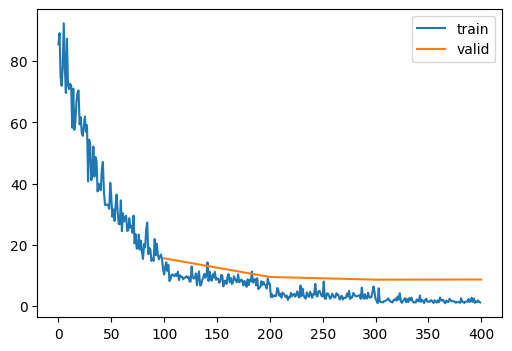

Making inference on test data


R2Score,loss,epoch,train,time
0.021,45.673,0,False,00:00


R2Score,loss,epoch,train,time
0.170,38.728,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 8.8804,  0.0000],
        [10.6066,  4.0000],
        [ 8.4755,  8.0000],
        [ 9.4719, 12.0000],
        [11.2256, 16.0000],
        [20.5347, 20.0000],
        [15.3736,  0.0000],
        [ 7.4185,  4.0000],
        [13.4758,  8.0000],
        [12.1939, 12.0000],
        [23.3726, 16.0000],
        [22.0517, 20.0000]])
result:  tensor(0.1271)


R2Score,loss,epoch,train,time
-0.221,56.962,0,False,00:00


R2Score,loss,epoch,train,time
-0.573,73.419,0,False,00:00


Inference on xr
		preds, targs
tensor([[-0.2171,  0.0000],
        [12.1058,  4.0000],
        [13.1179,  8.0000],
        [11.7808, 12.0000],
        [11.5901, 16.0000],
        [11.4782, 20.0000],
        [19.5433,  0.0000],
        [12.9753,  4.0000],
        [15.6383,  8.0000],
        [14.9881, 12.0000],
        [10.2947, 16.0000],
        [15.6276, 20.0000]])
result:  tensor(-0.3670)


R2Score,loss,epoch,train,time
0.740,12.285,0,False,00:00


R2Score,loss,epoch,train,time
0.409,27.918,0,False,00:00


Inference on gro
		preds, targs
tensor([[10.0831,  1.0000],
        [ 8.5071,  4.0000],
        [ 9.1126,  7.0000],
        [ 8.0034, 10.0000],
        [13.5113, 13.0000],
        [19.2430, 16.0000],
        [18.9691, 19.0000],
        [18.4692, 22.0000]])
result:  tensor(0.6441)


R2Score,loss,epoch,train,time
0.189,37.841,0,False,00:00


R2Score,loss,epoch,train,time
0.699,14.051,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 8.0092,  2.0000],
        [ 8.8725,  6.0000],
        [ 9.4409, 10.0000],
        [12.7101, 14.0000],
        [20.7422, 18.0000],
        [23.5274, 22.0000],
        [ 9.8086,  2.0000],
        [10.9175,  6.0000],
        [11.7997, 10.0000],
        [11.1970, 14.0000],
        [21.1077, 18.0000],
        [16.3360, 22.0000]])
result:  tensor(0.6532)


In [56]:
lr, epochs = 6e-4, 4
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


R2Score,loss,epoch,train,time
0.193,37.816,0,True,00:02
0.702,13.867,0,False,00:00
0.827,8.116,1,True,00:03
0.813,8.695,1,False,00:00
0.928,3.399,2,True,00:02
0.832,7.847,2,False,00:00
0.966,1.600,3,True,00:02
0.840,7.455,3,False,00:00
0.982,0.865,4,True,00:02
0.841,7.425,4,False,00:00


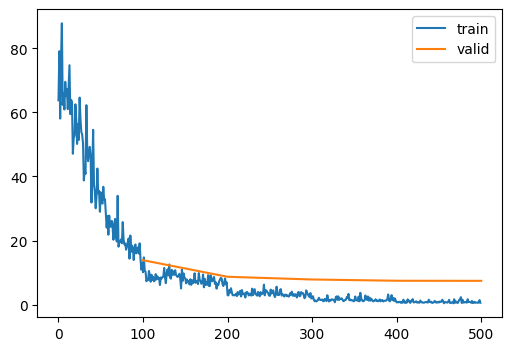

R2Score,loss,epoch,train,time
0.124,41.045,0,True,00:03
0.693,14.307,0,False,00:00
0.827,8.131,1,True,00:02
0.805,9.065,1,False,00:00
0.929,3.327,2,True,00:02
0.823,8.230,2,False,00:00
0.964,1.702,3,True,00:02
0.827,8.079,3,False,00:00
0.979,0.973,4,True,00:03
0.828,8.007,4,False,00:00


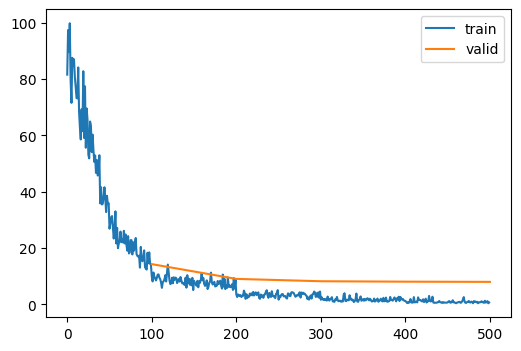

Making inference on test data


R2Score,loss,epoch,train,time
0.399,28.061,0,False,00:00


R2Score,loss,epoch,train,time
0.343,30.683,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 6.0640,  0.0000],
        [ 7.3360,  4.0000],
        [ 6.5324,  8.0000],
        [12.3016, 12.0000],
        [12.1518, 16.0000],
        [22.2006, 20.0000],
        [13.3628,  0.0000],
        [ 5.3928,  4.0000],
        [12.6468,  8.0000],
        [11.4754, 12.0000],
        [23.3005, 16.0000],
        [24.1818, 20.0000]])
result:  tensor(0.3876)


R2Score,loss,epoch,train,time
-0.287,60.065,0,False,00:00


R2Score,loss,epoch,train,time
-0.091,50.913,0,False,00:00


Inference on xr
		preds, targs
tensor([[ 0.6757,  0.0000],
        [10.7147,  4.0000],
        [10.7837,  8.0000],
        [11.9417, 12.0000],
        [14.6822, 16.0000],
        [11.6814, 20.0000],
        [17.7633,  0.0000],
        [15.6918,  4.0000],
        [11.6963,  8.0000],
        [12.5303, 12.0000],
        [14.1464, 16.0000],
        [13.7199, 20.0000]])
result:  tensor(-0.1309)


R2Score,loss,epoch,train,time
0.475,24.801,0,False,00:00


R2Score,loss,epoch,train,time
0.671,15.541,0,False,00:00


Inference on gro
		preds, targs
tensor([[11.4547,  1.0000],
        [ 7.8795,  4.0000],
        [ 9.8785,  7.0000],
        [ 9.3494, 10.0000],
        [15.9150, 13.0000],
        [14.0974, 16.0000],
        [21.3705, 19.0000],
        [22.9279, 22.0000]])
result:  tensor(0.5988)


R2Score,loss,epoch,train,time
0.462,25.100,0,False,00:00


R2Score,loss,epoch,train,time
0.393,28.305,0,False,00:00


Inference on rna
		preds, targs
tensor([[12.5196,  2.0000],
        [10.6886,  6.0000],
        [ 8.4173, 10.0000],
        [13.0265, 14.0000],
        [22.4412, 18.0000],
        [23.1843, 22.0000],
        [11.4085,  2.0000],
        [ 8.8201,  6.0000],
        [13.2790, 10.0000],
        [14.3566, 14.0000],
        [22.4541, 18.0000],
        [18.0870, 22.0000]])
result:  tensor(0.4648)


In [57]:
lr, epochs = 6e-4, 5
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Dropout

In [58]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 1),
    TimeLayer(),
]).apply(init_params)

Training models


R2Score,loss,epoch,train,time
-1.145,100.552,0,True,00:02
0.302,32.516,0,False,00:00
-0.113,52.169,1,True,00:03
0.618,17.772,1,False,00:00


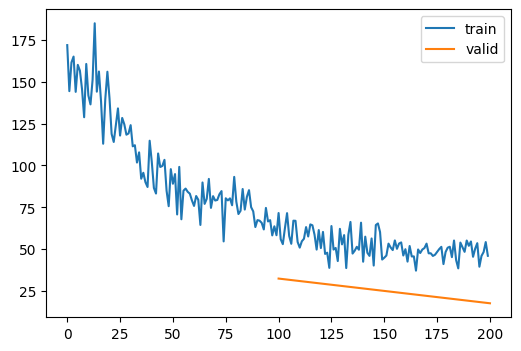

R2Score,loss,epoch,train,time
-0.724,80.817,0,True,00:02
0.581,19.498,0,False,00:00
0.206,37.206,1,True,00:02
0.756,11.363,1,False,00:00


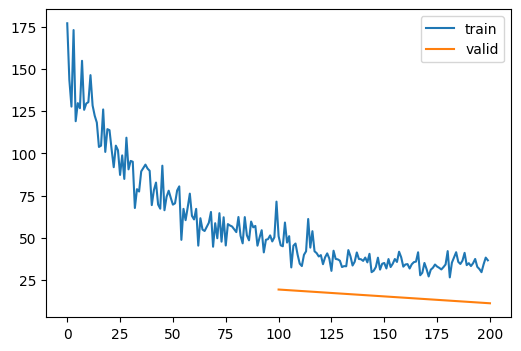

Making inference on test data


R2Score,loss,epoch,train,time
-0.247,58.211,0,False,00:00


R2Score,loss,epoch,train,time
0.525,22.156,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 9.5566,  0.0000],
        [ 5.3777,  4.0000],
        [-0.7295,  8.0000],
        [11.8845, 12.0000],
        [11.7152, 16.0000],
        [20.6543, 20.0000],
        [12.8975,  0.0000],
        [ 0.0963,  4.0000],
        [12.0710,  8.0000],
        [11.9584, 12.0000],
        [20.4272, 16.0000],
        [24.2009, 20.0000]])
result:  tensor(0.2435)


R2Score,loss,epoch,train,time
-0.354,63.180,0,False,00:00


R2Score,loss,epoch,train,time
-0.472,68.710,0,False,00:00


Inference on xr
		preds, targs
tensor([[-0.3391,  0.0000],
        [ 9.0644,  4.0000],
        [11.6131,  8.0000],
        [ 8.3770, 12.0000],
        [17.4864, 16.0000],
        [ 9.9130, 20.0000],
        [18.0426,  0.0000],
        [14.9192,  4.0000],
        [14.6710,  8.0000],
        [12.5259, 12.0000],
        [22.2314, 16.0000],
        [13.2880, 20.0000]])
result:  tensor(-0.3024)


R2Score,loss,epoch,train,time
-0.798,84.965,0,False,00:00


R2Score,loss,epoch,train,time
0.022,46.198,0,False,00:00


Inference on gro
		preds, targs
tensor([[22.4687,  1.0000],
        [ 2.4194,  4.0000],
        [ 7.5984,  7.0000],
        [ 6.9132, 10.0000],
        [13.1515, 13.0000],
        [12.3035, 16.0000],
        [20.9487, 19.0000],
        [22.4269, 22.0000]])
result:  tensor(-0.2988)


R2Score,loss,epoch,train,time
0.500,23.327,0,False,00:00


R2Score,loss,epoch,train,time
0.803,9.214,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 6.0666,  2.0000],
        [ 8.7910,  6.0000],
        [ 8.0477, 10.0000],
        [12.7447, 14.0000],
        [20.8168, 18.0000],
        [23.4416, 22.0000],
        [ 6.6534,  2.0000],
        [-0.1422,  6.0000],
        [12.3062, 10.0000],
        [12.4101, 14.0000],
        [23.9944, 18.0000],
        [17.5301, 22.0000]])
result:  tensor(0.7092)


In [59]:
lr, epochs = 1e-3, 2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


R2Score,loss,epoch,train,time
-0.792,84.016,0,True,00:03
0.606,18.342,0,False,00:00
0.245,35.375,1,True,00:02
0.808,8.927,1,False,00:00
0.516,22.701,2,True,00:02
0.802,9.211,2,False,00:00


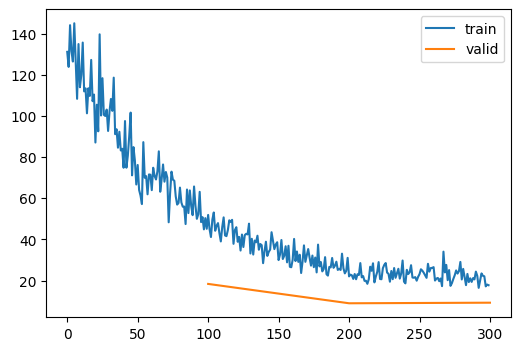

R2Score,loss,epoch,train,time
-0.992,93.367,0,True,00:02
0.494,23.570,0,False,00:00
0.184,38.237,1,True,00:03
0.757,11.312,1,False,00:00
0.484,24.205,2,True,00:02
0.764,10.982,2,False,00:00


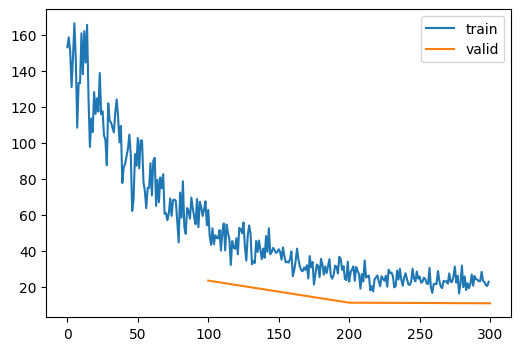

Making inference on test data


R2Score,loss,epoch,train,time
0.261,34.489,0,False,00:00


R2Score,loss,epoch,train,time
0.335,31.021,0,False,00:00


Inference on nascent
		preds, targs
tensor([[10.5092,  0.0000],
        [ 9.3850,  4.0000],
        [ 6.2497,  8.0000],
        [12.4467, 12.0000],
        [12.5729, 16.0000],
        [17.5268, 20.0000],
        [12.7308,  0.0000],
        [ 3.3215,  4.0000],
        [11.3209,  8.0000],
        [13.1716, 12.0000],
        [19.5919, 16.0000],
        [18.7157, 20.0000]])
result:  tensor(0.3749)


R2Score,loss,epoch,train,time
0.170,38.731,0,False,00:00


R2Score,loss,epoch,train,time
0.049,44.369,0,False,00:00


Inference on xr
		preds, targs
tensor([[-3.0890,  0.0000],
        [11.0553,  4.0000],
        [11.7194,  8.0000],
        [10.9153, 12.0000],
        [17.1913, 16.0000],
        [12.9312, 20.0000],
        [14.1164,  0.0000],
        [13.5213,  4.0000],
        [13.4844,  8.0000],
        [12.2320, 12.0000],
        [18.6193, 16.0000],
        [15.3919, 20.0000]])
result:  tensor(0.1538)


R2Score,loss,epoch,train,time
0.290,33.566,0,False,00:00


R2Score,loss,epoch,train,time
0.213,37.203,0,False,00:00


Inference on gro
		preds, targs
tensor([[16.4692,  1.0000],
        [ 5.7216,  4.0000],
        [10.1938,  7.0000],
        [10.1731, 10.0000],
        [12.7160, 13.0000],
        [15.8355, 16.0000],
        [17.9378, 19.0000],
        [18.7423, 22.0000]])
result:  tensor(0.3007)


R2Score,loss,epoch,train,time
0.665,15.640,0,False,00:00


R2Score,loss,epoch,train,time
0.579,19.646,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 7.1118,  2.0000],
        [10.9895,  6.0000],
        [10.8305, 10.0000],
        [13.5605, 14.0000],
        [17.7660, 18.0000],
        [19.0095, 22.0000],
        [11.0828,  2.0000],
        [ 9.4551,  6.0000],
        [12.3912, 10.0000],
        [12.0103, 14.0000],
        [20.1367, 18.0000],
        [17.1559, 22.0000]])
result:  tensor(0.6553)


In [60]:
lr, epochs = 1e-3, 3
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


R2Score,loss,epoch,train,time
-1.298,107.749,0,True,00:03
0.291,33.017,0,False,00:00
-0.156,54.205,1,True,00:02
0.745,11.899,1,False,00:00
0.378,29.168,2,True,00:02
0.774,10.532,2,False,00:00
0.521,22.432,3,True,00:02
0.775,10.483,3,False,00:00


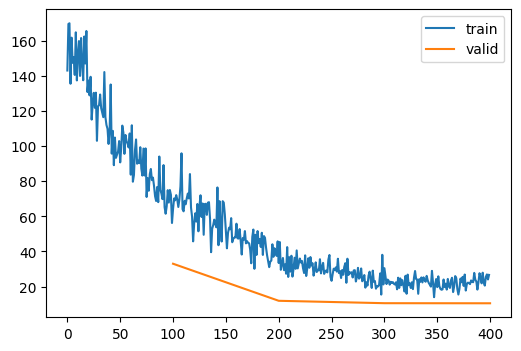

R2Score,loss,epoch,train,time
-1.059,96.508,0,True,00:03
0.464,24.976,0,False,00:00
0.113,41.562,1,True,00:02
0.764,11.007,1,False,00:00
0.510,22.980,2,True,00:02
0.791,9.739,2,False,00:00
0.609,18.314,3,True,00:03
0.798,9.393,3,False,00:00


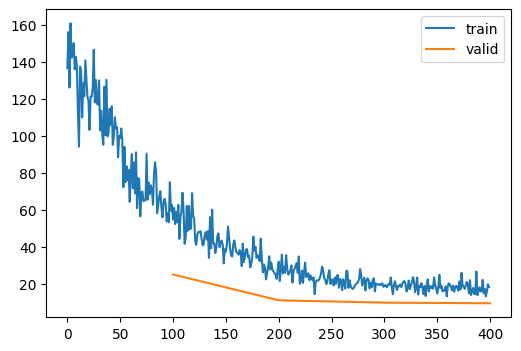

Making inference on test data


R2Score,loss,epoch,train,time
0.410,27.513,0,False,00:00


R2Score,loss,epoch,train,time
0.356,30.030,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 8.9958,  0.0000],
        [ 7.7501,  4.0000],
        [ 5.1873,  8.0000],
        [11.5764, 12.0000],
        [12.5764, 16.0000],
        [14.7764, 20.0000],
        [12.7926,  0.0000],
        [ 4.2703,  4.0000],
        [11.4923,  8.0000],
        [11.9946, 12.0000],
        [18.6953, 16.0000],
        [17.7291, 20.0000]])
result:  tensor(0.4100)


R2Score,loss,epoch,train,time
0.198,37.405,0,False,00:00


R2Score,loss,epoch,train,time
0.035,45.052,0,False,00:00


Inference on xr
		preds, targs
tensor([[ 2.5296,  0.0000],
        [ 9.2966,  4.0000],
        [11.4639,  8.0000],
        [10.1948, 12.0000],
        [13.3395, 16.0000],
        [11.1088, 20.0000],
        [13.3855,  0.0000],
        [13.7015,  4.0000],
        [13.0814,  8.0000],
        [12.6931, 12.0000],
        [14.3979, 16.0000],
        [13.6801, 20.0000]])
result:  tensor(0.1465)


R2Score,loss,epoch,train,time
0.162,39.592,0,False,00:00


R2Score,loss,epoch,train,time
0.161,39.638,0,False,00:00


Inference on gro
		preds, targs
tensor([[17.6047,  1.0000],
        [ 4.9959,  4.0000],
        [ 8.0924,  7.0000],
        [ 8.1345, 10.0000],
        [12.5362, 13.0000],
        [13.0077, 16.0000],
        [16.6437, 19.0000],
        [17.7461, 22.0000]])
result:  tensor(0.1688)


R2Score,loss,epoch,train,time
0.452,25.552,0,False,00:00


R2Score,loss,epoch,train,time
0.636,17.004,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 9.2774,  2.0000],
        [ 9.3821,  6.0000],
        [ 8.8776, 10.0000],
        [12.8296, 14.0000],
        [16.6789, 18.0000],
        [16.9699, 22.0000],
        [11.0309,  2.0000],
        [ 9.6668,  6.0000],
        [11.2136, 10.0000],
        [11.5861, 14.0000],
        [20.3789, 18.0000],
        [15.5974, 22.0000]])
result:  tensor(0.5660)


In [61]:
lr, epochs = 1e-3, 4
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


R2Score,loss,epoch,train,time
-1.767,129.729,0,True,00:02
0.259,34.495,0,False,00:00
-0.296,60.738,1,True,00:02
0.655,16.048,1,False,00:00
0.244,35.456,2,True,00:03
0.790,9.781,2,False,00:00
0.512,22.868,3,True,00:02
0.804,9.118,3,False,00:00
0.589,19.257,4,True,00:02
0.803,9.166,4,False,00:00


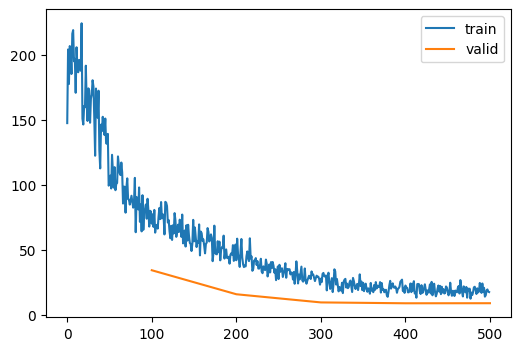

R2Score,loss,epoch,train,time
-0.962,91.963,0,True,00:02
0.442,25.974,0,False,00:00
0.110,41.741,1,True,00:03
0.757,11.299,1,False,00:00
0.549,21.130,2,True,00:02
0.810,8.851,2,False,00:00
0.675,15.215,3,True,00:02
0.811,8.819,3,False,00:00
0.715,13.352,4,True,00:02
0.819,8.408,4,False,00:00


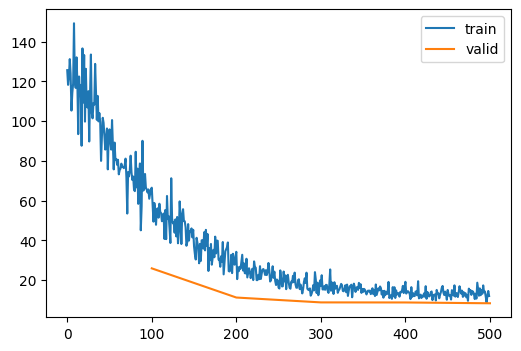

Making inference on test data


R2Score,loss,epoch,train,time
0.010,46.212,0,False,00:00


R2Score,loss,epoch,train,time
0.159,39.264,0,False,00:00


Inference on nascent
		preds, targs
tensor([[10.9313,  0.0000],
        [10.3702,  4.0000],
        [10.3256,  8.0000],
        [13.4388, 12.0000],
        [14.8328, 16.0000],
        [16.9161, 20.0000],
        [15.7709,  0.0000],
        [ 8.1274,  4.0000],
        [12.5836,  8.0000],
        [12.9167, 12.0000],
        [21.8509, 16.0000],
        [19.8437, 20.0000]])
result:  tensor(0.1066)


R2Score,loss,epoch,train,time
-0.076,50.225,0,False,00:00


R2Score,loss,epoch,train,time
-0.034,48.263,0,False,00:00


Inference on xr
		preds, targs
tensor([[ 5.8351,  0.0000],
        [11.5636,  4.0000],
        [13.0065,  8.0000],
        [11.8578, 12.0000],
        [14.2946, 16.0000],
        [12.9728, 20.0000],
        [15.4339,  0.0000],
        [13.7677,  4.0000],
        [15.0234,  8.0000],
        [12.8147, 12.0000],
        [16.2638, 16.0000],
        [14.7055, 20.0000]])
result:  tensor(-0.0363)


R2Score,loss,epoch,train,time
-0.177,55.602,0,False,00:00


R2Score,loss,epoch,train,time
0.161,39.659,0,False,00:00


Inference on gro
		preds, targs
tensor([[19.2567,  1.0000],
        [ 7.9966,  4.0000],
        [10.4245,  7.0000],
        [11.3286, 10.0000],
        [13.1274, 13.0000],
        [15.8360, 16.0000],
        [16.5936, 19.0000],
        [19.2519, 22.0000]])
result:  tensor(0.0049)


R2Score,loss,epoch,train,time
0.192,37.726,0,False,00:00


R2Score,loss,epoch,train,time
0.316,31.911,0,False,00:00


Inference on rna
		preds, targs
tensor([[12.6586,  2.0000],
        [11.5185,  6.0000],
        [11.9435, 10.0000],
        [13.4457, 14.0000],
        [19.8931, 18.0000],
        [19.1330, 22.0000],
        [15.4366,  2.0000],
        [ 9.9947,  6.0000],
        [12.7740, 10.0000],
        [12.7762, 14.0000],
        [20.5615, 18.0000],
        [15.5417, 22.0000]])
result:  tensor(0.2609)


In [62]:
lr, epochs = 1e-3, 5
xtra = [get_sched(epochs, lr, dls)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Batchnorm

In [63]:
def get_model():
    return nn.Sequential(*[
    nn.Linear(len(indep_cols), 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 100),
    nn.BatchNorm1d(100),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(100, 1),
    nn.BatchNorm1d(1),
    TimeLayer()
]).apply(init_params)

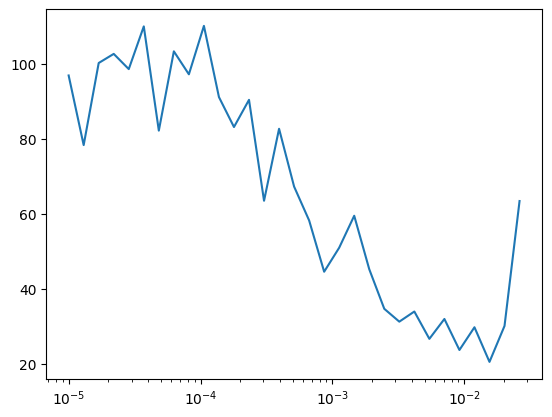

In [64]:
TrainLearner(get_model(), dls, loss_func, cbs=DeviceCB()).lr_find()

Training models


R2Score,loss,epoch,train,time
0.670,15.475,0,True,00:02
0.897,4.784,0,False,00:00
0.860,6.571,1,True,00:02
0.921,3.694,1,False,00:00
0.901,4.621,2,True,00:03
0.941,2.755,2,False,00:00
0.923,3.609,3,True,00:02
0.949,2.384,3,False,00:00


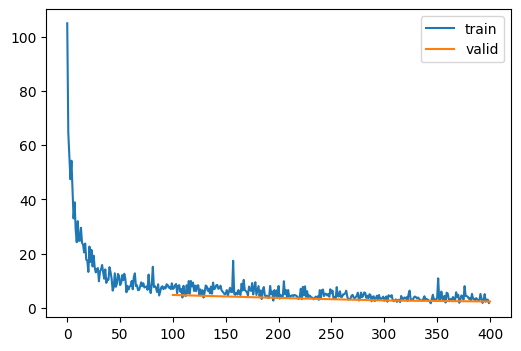

R2Score,loss,epoch,train,time
0.677,15.126,0,True,00:02
0.877,5.709,0,False,00:00
0.859,6.607,1,True,00:02
0.923,3.604,1,False,00:00
0.897,4.847,2,True,00:03
0.921,3.683,2,False,00:00
0.922,3.652,3,True,00:02
0.955,2.111,3,False,00:00


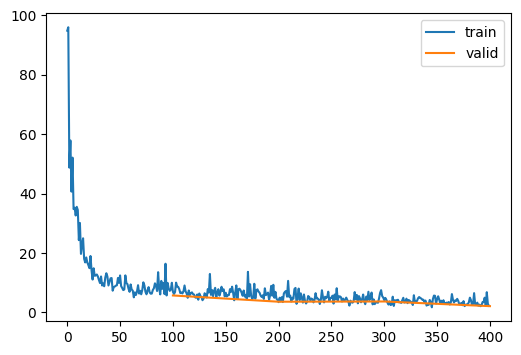

Making inference on test data


R2Score,loss,epoch,train,time
0.497,23.464,0,False,00:00


R2Score,loss,epoch,train,time
0.517,22.563,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 4.1280,  0.0000],
        [ 6.4137,  4.0000],
        [ 9.0086,  8.0000],
        [10.2645, 12.0000],
        [14.0319, 16.0000],
        [17.5737, 20.0000],
        [14.0907,  0.0000],
        [ 4.0276,  4.0000],
        [12.1633,  8.0000],
        [11.4466, 12.0000],
        [20.6202, 16.0000],
        [19.7208, 20.0000]])
result:  tensor(0.5102)


R2Score,loss,epoch,train,time
-0.603,74.789,0,False,00:00


R2Score,loss,epoch,train,time
-0.455,67.911,0,False,00:00


Inference on xr
		preds, targs
tensor([[ 7.8935,  0.0000],
        [11.0546,  4.0000],
        [10.8580,  8.0000],
        [10.3510, 12.0000],
        [16.7261, 16.0000],
        [ 6.5311, 20.0000],
        [19.3373,  0.0000],
        [16.2534,  4.0000],
        [12.0645,  8.0000],
        [12.0157, 12.0000],
        [16.6308, 16.0000],
        [17.3935, 20.0000]])
result:  tensor(-0.5227)


R2Score,loss,epoch,train,time
-0.056,49.916,0,False,00:00


R2Score,loss,epoch,train,time
-0.139,53.806,0,False,00:00


Inference on gro
		preds, targs
tensor([[20.9513,  1.0000],
        [ 5.5244,  4.0000],
        [ 9.5540,  7.0000],
        [10.4685, 10.0000],
        [13.0307, 13.0000],
        [15.1494, 16.0000],
        [18.6257, 19.0000],
        [19.5483, 22.0000]])
result:  tensor(-0.0952)


R2Score,loss,epoch,train,time
0.844,7.286,0,False,00:00


R2Score,loss,epoch,train,time
0.873,5.943,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 5.9409,  2.0000],
        [ 8.6168,  6.0000],
        [10.3409, 10.0000],
        [13.7224, 14.0000],
        [20.0307, 18.0000],
        [20.5303, 22.0000],
        [ 6.0068,  2.0000],
        [ 8.8442,  6.0000],
        [10.9662, 10.0000],
        [12.1349, 14.0000],
        [19.9285, 18.0000],
        [17.9161, 22.0000]])
result:  tensor(0.8611)


In [65]:
lr, epochs = .1, 4
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


R2Score,loss,epoch,train,time
0.661,15.889,0,True,00:03
0.911,4.146,0,False,00:00
0.854,6.863,1,True,00:03
0.920,3.736,1,False,00:00
0.869,6.127,2,True,00:02
0.930,3.245,2,False,00:00
0.906,4.408,3,True,00:02
0.948,2.401,3,False,00:00
0.926,3.462,4,True,00:03
0.950,2.316,4,False,00:00


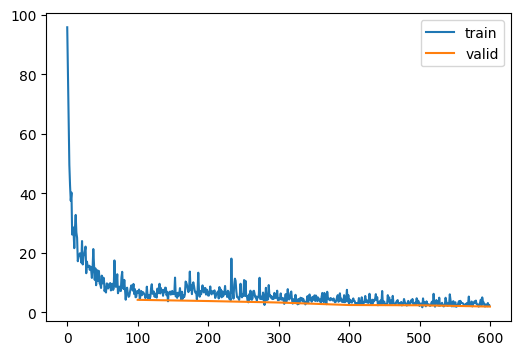

R2Score,loss,epoch,train,time
0.687,14.663,0,True,00:02
0.915,3.972,0,False,00:00
0.862,6.460,1,True,00:02
0.928,3.351,1,False,00:00
0.883,5.493,2,True,00:03
0.941,2.741,2,False,00:00
0.914,4.015,3,True,00:02
0.948,2.419,3,False,00:00
0.928,3.378,4,True,00:02
0.958,1.939,4,False,00:00


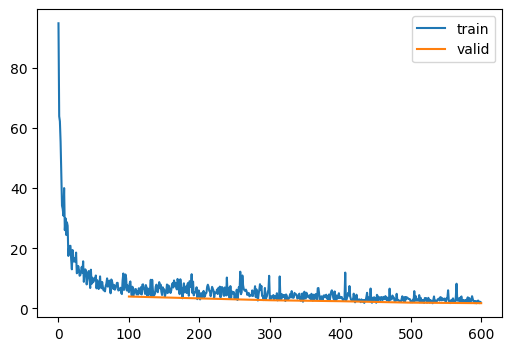

Making inference on test data


R2Score,loss,epoch,train,time
0.527,22.094,0,False,00:00


R2Score,loss,epoch,train,time
0.580,19.607,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 2.9518,  0.0000],
        [ 6.2381,  4.0000],
        [ 9.1806,  8.0000],
        [ 9.8636, 12.0000],
        [14.2928, 16.0000],
        [18.2208, 20.0000],
        [13.9278,  0.0000],
        [ 4.1940,  4.0000],
        [11.3771,  8.0000],
        [11.3538, 12.0000],
        [20.0827, 16.0000],
        [19.4640, 20.0000]])
result:  tensor(0.5561)


R2Score,loss,epoch,train,time
-0.810,84.474,0,False,00:00


R2Score,loss,epoch,train,time
-0.765,82.382,0,False,00:00


Inference on xr
		preds, targs
tensor([[ 9.2852,  0.0000],
        [12.6886,  4.0000],
        [10.4682,  8.0000],
        [ 9.8880, 12.0000],
        [16.8115, 16.0000],
        [ 4.9727, 20.0000],
        [20.0696,  0.0000],
        [16.7697,  4.0000],
        [11.7698,  8.0000],
        [11.2915, 12.0000],
        [16.8244, 16.0000],
        [17.8206, 20.0000]])
result:  tensor(-0.7585)


R2Score,loss,epoch,train,time
-0.210,57.179,0,False,00:00


R2Score,loss,epoch,train,time
-0.031,48.735,0,False,00:00


Inference on gro
		preds, targs
tensor([[21.1799,  1.0000],
        [ 5.5212,  4.0000],
        [ 9.2352,  7.0000],
        [10.4896, 10.0000],
        [12.8608, 13.0000],
        [14.8453, 16.0000],
        [18.1305, 19.0000],
        [19.6832, 22.0000]])
result:  tensor(-0.1171)


R2Score,loss,epoch,train,time
0.906,4.374,0,False,00:00


R2Score,loss,epoch,train,time
0.892,5.059,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 4.0455,  2.0000],
        [ 8.2370,  6.0000],
        [10.0805, 10.0000],
        [13.6268, 14.0000],
        [19.9906, 18.0000],
        [20.3095, 22.0000],
        [ 4.9110,  2.0000],
        [ 8.5433,  6.0000],
        [10.7131, 10.0000],
        [11.5750, 14.0000],
        [19.8231, 18.0000],
        [18.1683, 22.0000]])
result:  tensor(0.9009)


In [66]:
lr, epochs = .1, 6
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

Training models


R2Score,loss,epoch,train,time
0.666,15.659,0,True,00:02
0.920,3.723,0,False,00:00
0.855,6.806,1,True,00:02
0.914,4.018,1,False,00:00
0.885,5.374,2,True,00:03
0.935,3.044,2,False,00:00
0.909,4.289,3,True,00:02
0.948,2.408,3,False,00:00
0.926,3.461,4,True,00:02
0.960,1.857,4,False,00:00


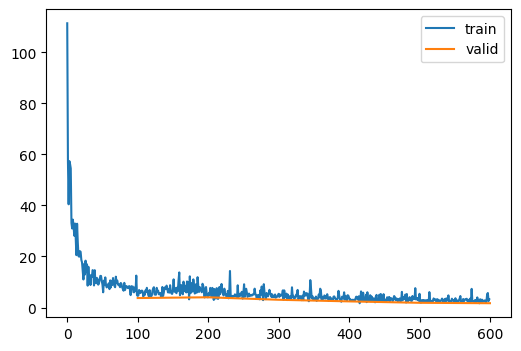

R2Score,loss,epoch,train,time
0.653,16.267,0,True,00:03
0.914,3.996,0,False,00:00
0.852,6.930,1,True,00:02
0.882,5.478,1,False,00:00
0.872,6.023,2,True,00:02
0.936,3.003,2,False,00:00
0.907,4.378,3,True,00:03
0.944,2.608,3,False,00:00
0.926,3.493,4,True,00:02
0.952,2.256,4,False,00:00


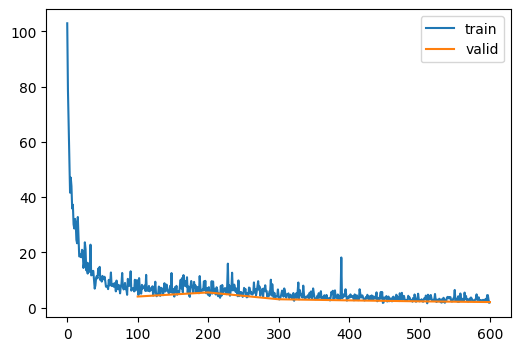

Making inference on test data


R2Score,loss,epoch,train,time
0.607,18.346,0,False,00:00


R2Score,loss,epoch,train,time
0.435,26.376,0,False,00:00


Inference on nascent
		preds, targs
tensor([[ 3.6897,  0.0000],
        [ 5.8401,  4.0000],
        [ 8.9936,  8.0000],
        [10.0441, 12.0000],
        [14.2918, 16.0000],
        [17.6538, 20.0000],
        [14.4439,  0.0000],
        [ 4.0650,  4.0000],
        [12.0330,  8.0000],
        [11.3995, 12.0000],
        [19.1508, 16.0000],
        [19.6549, 20.0000]])
result:  tensor(0.5258)


R2Score,loss,epoch,train,time
-0.565,73.014,0,False,00:00


R2Score,loss,epoch,train,time
-0.629,76.006,0,False,00:00


Inference on xr
		preds, targs
tensor([[ 7.8090,  0.0000],
        [11.9614,  4.0000],
        [10.6504,  8.0000],
        [10.0351, 12.0000],
        [16.8199, 16.0000],
        [ 6.6332, 20.0000],
        [19.4474,  0.0000],
        [16.9996,  4.0000],
        [12.1354,  8.0000],
        [12.3311, 12.0000],
        [16.7011, 16.0000],
        [17.6534, 20.0000]])
result:  tensor(-0.5804)


R2Score,loss,epoch,train,time
-0.059,50.048,0,False,00:00


R2Score,loss,epoch,train,time
-0.129,53.334,0,False,00:00


Inference on gro
		preds, targs
tensor([[20.9550,  1.0000],
        [ 5.1690,  4.0000],
        [ 9.5040,  7.0000],
        [10.3885, 10.0000],
        [12.9734, 13.0000],
        [15.2248, 16.0000],
        [18.4347, 19.0000],
        [19.4992, 22.0000]])
result:  tensor(-0.0930)


R2Score,loss,epoch,train,time
0.918,3.808,0,False,00:00


R2Score,loss,epoch,train,time
0.876,5.797,0,False,00:00


Inference on rna
		preds, targs
tensor([[ 3.8232,  2.0000],
        [ 8.2523,  6.0000],
        [10.1611, 10.0000],
        [13.8768, 14.0000],
        [19.4883, 18.0000],
        [20.5327, 22.0000],
        [ 5.5574,  2.0000],
        [ 8.2667,  6.0000],
        [11.0250, 10.0000],
        [12.1364, 14.0000],
        [20.5131, 18.0000],
        [18.3310, 22.0000]])
result:  tensor(0.9020)


In [67]:
lr, epochs = .1, 6
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
ensemble_model(nlearn, get_model, epochs=epochs, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

## Conclusion

Unfortunately, deeper network did not perform better on bulk data than shallower network even if they did better on scRNA-seq data. Maybe because the training data is too noisy with random numbers.